In [1]:
import import_ipynb
from ConsistencyIndexes import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


In [2]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.encoder1 = UNetBlock(3, 64)
        self.encoder2 = UNetBlock(64, 128)
        self.encoder3 = UNetBlock(128, 256)       
        self.middle = UNetBlock(256, 256)       
        self.decoder3 = UNetBlock(256, 128)
        self.decoder2 = UNetBlock(128, 64)
        self.decoder1 = UNetBlock(64, 3)    
    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(nn.functional.max_pool2d(x1, 2))
        x3 = self.encoder3(nn.functional.max_pool2d(x2, 2))       
        # Middle block
        x_middle = self.middle(x3)       
        # Decoder
        x = nn.functional.interpolate(self.decoder3(x_middle), scale_factor=2, mode='nearest')
        x = nn.functional.interpolate(self.decoder2(x + x2), scale_factor=2, mode='nearest')
        x = self.decoder1(x + x1)       
        return x
# Noise scheduler for adding noise
class NoiseScheduler:
    def __init__(self, num_steps):
        self.num_steps = num_steps
        self.betas = torch.linspace(0.0001, 0.02, num_steps)
    def add_noise(self, x, t):
        beta_t = self.betas[t]
        noise = torch.randn_like(x)
        noisy_img = torch.sqrt(1 - beta_t) * x + torch.sqrt(beta_t) * noise
        return noisy_img, noise

In [3]:
def train_diffusion(model, images, noise_scheduler, num_epochs=10, num_steps=1000, lr=0.001, num_img=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0       
        for i, img in enumerate(images):
            img = img.permute(2, 0, 1).unsqueeze(0).float()  # Convert to (batch_size, 3, 320, 640)
            for step in range(num_steps):
                # Select a random timestep
                t = torch.randint(0, num_steps, (1,)).item()               
                # Add noise to the image
                noisy_img, noise = noise_scheduler.add_noise(img, t)
                # Predict noise using the model
                optimizer.zero_grad()
                predicted_noise = model(noisy_img)                
                # Calculate loss (MSE between predicted noise and actual noise)
                loss = criterion(predicted_noise, noise)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                clear_output()
                # Display images and predictions
                if step % 1 == 0:
                    predicted_img = noisy_img - predicted_noise
                    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
                    axs[0].imshow(torch.clamp((img[0]*255).permute(1,2,0).int(),0,255))
                    axs[0].set_title("Original Image")
                    axs[1].imshow(torch.clamp((noisy_img[0]*255).permute(1,2,0).int(),0,255))
                    axs[1].set_title(f"Noisy Image (Step {t})")
                    axs[2].imshow(torch.clamp((predicted_noise[0]*255).permute(1,2,0).int(),0,255))
                    axs[2].set_title("Predicted Noise")
                    axs[3].imshow(torch.clamp((predicted_img[0]*255).permute(1,2,0).int(),0,255))
                    axs[3].set_title("Predicted Image")
                    plt.show()
                print(f"Epoch {epoch + 1}, Image {i + 1}, Step {step}: Loss = {loss.item():.4f}")
            if i>num_img:
                break
        print(f"Average Loss for Epoch {epoch + 1}: {total_loss / len(images):.4f}")

In [4]:
def generate_image(model, img_size=(320, 640), num_steps=1000):
    model.eval()
    
    img = torch.randn(1, 3, *img_size)  # Start with random noise
    noise_scheduler = NoiseScheduler(num_steps)

    with torch.no_grad():
        for t in reversed(range(num_steps)):
            noisy_img, _ = noise_scheduler.add_noise(img, t)
            predicted_noise = model(noisy_img)
            img = noisy_img - predicted_noise  # Denoise step by step
            clear_output()
            if t % 1 == 0:
                img_np = img[0].permute(1, 2, 0).detach().cpu().numpy()
                plt.imshow(np.clip(img_np, 0, 1))
                plt.title(f"Generated Image (Step {t})")
                plt.show()

    return img[0].permute(1, 2, 0).detach().cpu().numpy()


In [13]:
images = read_first_frames('VDB',3)
images = [cv2.resize(i,(640,320)) for i in images]
images = [torch.tensor(i).float()/255.0 for i in images]

In [14]:
len(images)

84

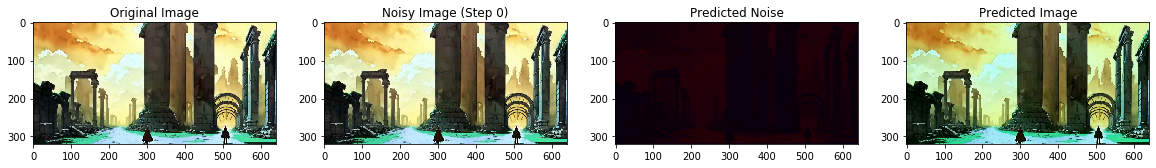

Epoch 1, Image 1, Step 0: Loss = 1.0028


KeyboardInterrupt: 

In [16]:
model = DiffusionModel()
Steps = 1
Epochs = 1
N_img = len(images)
noise_scheduler = NoiseScheduler(num_steps=Steps)
train_diffusion(model, images, noise_scheduler, num_epochs=Epochs, num_steps=Steps, num_img=N_img)

In [95]:
generated_img = generate_image(model, img_size=(320, 640), num_steps=100)

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),"t.pth")
model.load_state_dict(torch.load("t.pth"))
model.eval()